In [ ]:
import random
import numpy as np
import matplotlib as plt
import json
import glob
import torch
import re

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/cs6471proj2/amazon

Mounted at /content/drive
/content/drive/MyDrive/cs6471proj2/amazon


In [ ]:
done = ["reviews_Cell_Phones_and_Accessories_5", "reviews_Toys_and_Games_5", 
        "reviews_Office_Products_5", "reviews_Pet_Supplies_5", 'reviews_Tools_and_Home_Improvement_5',
        "reviews_Automotive_5", "reviews_Digital_Music_5", "reviews_Musical_Instruments_5", 
        "reviews_Clothing_Shoes_and_Jewelry_5", "reviews_Amazon_Instant_Video_5"]

country_worth2lookat = {'china':['china', 'ch'], 'us':['usa', 'us', 'america', 'united states', 'the states'], 
                      'uk':['uk', 'england', 'britain', 'ireland', 'scotland'], 'japan':['japan'], 'mexico':['mexico'], 'germany': ['germany'], 
                      'canada':['canada'], 'india':['india'], 'australia':['australia'], 'taiwan':['taiwan'], 'vietnam':['vietnam'], 
                      'thailand':['thailand'], 'korea':['korea'], 'iraq':['iraq'], 'russia':['russia']} #15


nationality_worth2lookat = {'american': ['american'], 'english': ['english'], 'german':['german'], 
                          'chinese':['chinese'], 'british':['british', 'scottish', 'irish'], 
                          'spanish':['spanish'], 'french':['french'], 'japanese':['japanese'], 
                          'european':['european'], 'australian':['australian'], 
                          'african':['african'], 'asian':['asian'], 'italian':['italian'], 
                          'canadian':['canadian'],  'indian':['indian'], 
                          'russian':['russian'], 'mexican':['mexican']} # 17

# build word2label
word2label_country = {}
word2label_nationality = {}
for key, item in country_worth2lookat.items():
    for word in item:
        word2label_country[word] = key
for key, item in nationality_worth2lookat.items():
    for word in item:
        word2label_nationality[word] = key

# data generation and clean (saved)

In [ ]:
# do we care about all data?
all_text = []
for name in done:
    for row_idx, review_line in enumerate(iter(open(name+'.json', 'r'))):
        review = json.loads(review_line)
        all_text.append(review['reviewText'])

In [ ]:
with open('/'.join(['bagofwords', 'word2vec_precleaned_country_nationality_all_text.json']), 'r') as f:
    all_words = json.load(f)

In [ ]:
# for test
with open('/'.join(['bagofwords', 'all_nationality_text.json']), 'r') as f:
    nation_text = json.load(f)
    print(len(nation_text))

# with open('/'.join(['bagofwords', 'all_country_text.json']), 'r') as f:
#     country_text = json.load(f)
#     print(len(country_text))

# text_all = nation_text + country_text
with open('purpose_classification_new/entire_training/all_dataset_complete_data.json', 'r') as f:
    f_data = json.load(f)

with open('purpose_classification_new/entire_training/entire_dataset_inference_results.json', 'r') as f:
    results = json.load(f)

idx_set = set()
for k, item in results.items():
    if int(item) == 0:
        idx_set.add(int(k))

print(len(idx_set))

# text2country
text2country = {}
for data in f_data:
    index = data[0]
    if int(index) in idx_set:
        if data[2] in text2country:
            text2country[data[2]].append(data[3]['country_name'])
        else:
            text2country[data[2]] = [data[3]['country_name']]

print(len(text2country))

country_text = []
for k, item in text2country.items():
    country_text.append(k.lower())

text_all = nation_text + country_text

19380
14751
11139


## preprocess

In [ ]:
import spacy
import re

nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    return ' '.join(txt)

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', row) for row in text_all)
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]



In [ ]:
with open('bagofwords_new/word2vec/cleaned_txt.json', 'w') as f:
    json.dump(txt, f)

In [ ]:
from gensim.models.phrases import Phrases, Phraser
all_words = [ws.split(' ') for ws in txt]
phrases = Phrases(all_words, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
all_words = bigram[all_words]

In [ ]:
from gensim.models import Word2Vec
import multiprocessing
from gensim.models.callbacks import CallbackAny2Vec
import time

cores = multiprocessing.cpu_count()

class MyLossCalculator(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1
        self.losses = []
        self.cumu_losses = []
        self.previous_epoch_time = time.time()

    def on_epoch_end(self, model):
        cumu_loss = model.get_latest_training_loss()
        loss = cumu_loss if self.epoch <= 1 else cumu_loss - self.cumu_losses[-1]
        norms = [linalg.norm(v) for v in model.wv.vectors]
        now = time.time()
        epoch_seconds = now - self.previous_epoch_time
        self.previous_epoch_time = now
        print(f"Loss after epoch {self.epoch}: {loss} / cumulative loss: {cumu_loss} "+\
              f" -> epoch took {round(epoch_seconds, 2)} s - vector norms min/avg/max: "+\
              f"{round(float(min(norms)), 2)}, {round(float(sum(norms)/len(norms)), 2)}, {round(float(max(norms)), 2)}")
        self.epoch += 1
        self.losses.append(loss)
        self.cumu_losses.append(cumu_loss)

w2v_model = Word2Vec(min_count=20,
                     window=10,
                     size=100,
                     sample=5e-6, 
                     negative=10,
                     workers=cores-1, 
                    alpha=0.1, 
                    min_alpha=0.001, 
                 compute_loss=True, callbacks=[MyLossCalculator()])
w2v_model.build_vocab(all_words, progress_per=10000)


In [ ]:
import numpy.linalg as linalg
w2v_model.train(all_words, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1, callbacks=[MyLossCalculator()])

Loss after epoch 1: 0.0 / cumulative loss: 0.0  -> epoch took 12.44 s - vector norms min/avg/max: 0.37, 1.86, 8.7
Loss after epoch 2: 0.0 / cumulative loss: 0.0  -> epoch took 12.43 s - vector norms min/avg/max: 0.65, 2.69, 9.95
Loss after epoch 3: 0.0 / cumulative loss: 0.0  -> epoch took 12.37 s - vector norms min/avg/max: 0.88, 3.66, 11.5
Loss after epoch 4: 0.0 / cumulative loss: 0.0  -> epoch took 12.75 s - vector norms min/avg/max: 1.57, 4.69, 14.17
Loss after epoch 5: 0.0 / cumulative loss: 0.0  -> epoch took 12.79 s - vector norms min/avg/max: 2.18, 5.69, 16.12
Loss after epoch 6: 0.0 / cumulative loss: 0.0  -> epoch took 12.44 s - vector norms min/avg/max: 2.93, 6.64, 16.04
Loss after epoch 7: 0.0 / cumulative loss: 0.0  -> epoch took 12.51 s - vector norms min/avg/max: 3.66, 7.49, 17.41
Loss after epoch 8: 0.0 / cumulative loss: 0.0  -> epoch took 12.5 s - vector norms min/avg/max: 4.27, 8.24, 17.9
Loss after epoch 9: 0.0 / cumulative loss: 0.0  -> epoch took 12.6 s - vector 

(29644197, 143084750)

In [ ]:
w2v_model.save("bagofwords_new/word2vec_text.model")
w2v_model.wv.save("bagofwords_new/word2vec_txt.wordvectors")
w2v_model.init_sims(replace=True)


In [ ]:
# w2v_model = Word2Vec(min_count=20,
#                      window=10,
#                      size=100,
#                      sample=5e-6, 
#                      negative=10,
#                      workers=cores-1, 
#                     alpha=0.1, 
#                     min_alpha=0.001, 
#                  compute_loss=True, callbacks=[MyLossCalculator()])
import gensim

w2v_model = gensim.models.Word2Vec.load("bagofwords_new/word2vec_text.model")
w2v_model.init_sims(replace=True)
w2v_model.wv.most_similar(positive=["chinese"], topn=100)

# Country only

In [ ]:
import spacy
import re

nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    return ' '.join(txt)

brief_cleaning = (re.sub("[^A-Za-z']+", ' ', row) for row in country_text)
txt_country = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

with open('bagofwords_new/word2vec/cleaned_country_txt.json', 'w') as f:
    json.dump(txt_country, f)

In [ ]:
with open('bagofwords_new/word2vec/cleaned_country_txt.json', 'r') as f:
    txt_country = json.load(f)

In [ ]:
from gensim.models.phrases import Phrases, Phraser
all_words_c = [ws.split(' ') for ws in txt_country]
phrases = Phrases(all_words_c, min_count=10, progress_per=10000)
bigram = Phraser(phrases)
all_words_c = bigram[all_words_c]

In [ ]:
from gensim.models import Word2Vec
import multiprocessing
from gensim.models.callbacks import CallbackAny2Vec
import time

cores = multiprocessing.cpu_count()

class MyLossCalculator(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1
        self.losses = []
        self.cumu_losses = []
        self.previous_epoch_time = time.time()

    def on_epoch_end(self, model):
        cumu_loss = model.get_latest_training_loss()
        loss = cumu_loss if self.epoch <= 1 else cumu_loss - self.cumu_losses[-1]
        norms = [linalg.norm(v) for v in model.wv.vectors]
        now = time.time()
        epoch_seconds = now - self.previous_epoch_time
        self.previous_epoch_time = now
        print(f"Loss after epoch {self.epoch}: {loss} / cumulative loss: {cumu_loss} "+\
              f" -> epoch took {round(epoch_seconds, 2)} s - vector norms min/avg/max: "+\
              f"{round(float(min(norms)), 2)}, {round(float(sum(norms)/len(norms)), 2)}, {round(float(max(norms)), 2)}")
        self.epoch += 1
        self.losses.append(loss)
        self.cumu_losses.append(cumu_loss)

w2v_model_c = Word2Vec(min_count=10,
                     window=10,
                     size=100,
                     sample=5e-6, 
                     negative=10,
                     workers=cores-1, 
                    alpha=0.05, 
                    min_alpha=0.001, 
                 compute_loss=True, callbacks=[MyLossCalculator()])
w2v_model_c.build_vocab(all_words_c, progress_per=10000)


In [ ]:
import numpy.linalg as linalg
w2v_model_c.train(all_words_c, total_examples=w2v_model_c.corpus_count, epochs=50, report_delay=1, callbacks=[MyLossCalculator()])

Loss after epoch 1: 0.0 / cumulative loss: 0.0  -> epoch took 3.17 s - vector norms min/avg/max: 0.04, 2.14, 7.02
Loss after epoch 2: 0.0 / cumulative loss: 0.0  -> epoch took 3.13 s - vector norms min/avg/max: 0.53, 2.13, 5.03
Loss after epoch 3: 0.0 / cumulative loss: 0.0  -> epoch took 3.15 s - vector norms min/avg/max: 0.59, 2.05, 3.69
Loss after epoch 4: 0.0 / cumulative loss: 0.0  -> epoch took 3.1 s - vector norms min/avg/max: 0.93, 1.98, 3.56
Loss after epoch 5: 0.0 / cumulative loss: 0.0  -> epoch took 3.09 s - vector norms min/avg/max: 0.99, 1.91, 3.23
Loss after epoch 6: 0.0 / cumulative loss: 0.0  -> epoch took 3.15 s - vector norms min/avg/max: 0.95, 1.87, 4.38
Loss after epoch 7: 0.0 / cumulative loss: 0.0  -> epoch took 3.13 s - vector norms min/avg/max: 1.19, 1.91, 8.33
Loss after epoch 8: 0.0 / cumulative loss: 0.0  -> epoch took 3.21 s - vector norms min/avg/max: 1.14, 2.07, 11.36
Loss after epoch 9: 0.0 / cumulative loss: 0.0  -> epoch took 3.12 s - vector norms min/

(6090286, 38813950)

In [ ]:
# w2v_model = Word2Vec(min_count=20,
#                      window=10,
#                      size=100,
#                      sample=5e-6, 
#                      negative=10,
#                      workers=cores-1, 
#                     alpha=0.1, 
#                     min_alpha=0.001, 
#                  compute_loss=True, callbacks=[MyLossCalculator()])
# import gensim

# w2v_mw2v_model_codel = gensim.models.Word2Vec.load("bagofwords_new/word2vec_text.model")
w2v_model_c.init_sims(replace=True)
w2v_model_c.wv.most_similar(positive=["china"], topn=100)
w2v_model_c.save("bagofwords_new/country_only_word2vec_text.model")
w2v_model_c.wv.save("bagofwords_new/country_only_word2vec_txt.wordvectors")

# Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from gensim.models import Word2Vec
import multiprocessing
from gensim.models.callbacks import CallbackAny2Vec
import time

cores = multiprocessing.cpu_count()

import nltk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.corpus import opinion_lexicon
nltk.download('opinion_lexicon')
pos_list=set(opinion_lexicon.positive())
neg_list=set(opinion_lexicon.negative())

w2v_model = gensim.models.Word2Vec.load("bagofwords_new/country_only_word2vec_text.model")
w2v_model.init_sims(replace=True)

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [ ]:
import gensim

class MyLossCalculator(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1
        self.losses = []
        self.cumu_losses = []
        self.previous_epoch_time = time.time()

    def on_epoch_end(self, model):
        cumu_loss = model.get_latest_training_loss()
        loss = cumu_loss if self.epoch <= 1 else cumu_loss - self.cumu_losses[-1]
        norms = [linalg.norm(v) for v in model.wv.vectors]
        now = time.time()
        epoch_seconds = now - self.previous_epoch_time
        self.previous_epoch_time = now
        print(f"Loss after epoch {self.epoch}: {loss} / cumulative loss: {cumu_loss} "+\
              f" -> epoch took {round(epoch_seconds, 2)} s - vector norms min/avg/max: "+\
              f"{round(float(min(norms)), 2)}, {round(float(sum(norms)/len(norms)), 2)}, {round(float(max(norms)), 2)}")
        self.epoch += 1
        self.losses.append(loss)
        self.cumu_losses.append(cumu_loss)


In [ ]:
country_worth2lookat = {'china':['china', 'ch'], 'us':['usa', 'us', 'america', 'united states', 'the states'], 
                      'uk':['uk', 'england', 'britain', 'ireland', 'scotland'], 'japan':['japan'], 'mexico':['mexico'], 'germany': ['germany'], 
                      'canada':['canada'], 'india':['india'], 'australia':['australia'], 'taiwan':['taiwan'], 'vietnam':['vietnam'], 
                      'thailand':['thailand'], 'korea':['korea'], 'iraq':['iraq'], 'russia':['russia']} #15


nationality_worth2lookat = {'american': ['american'], 'english': ['english'], 'german':['german'], 
                          'chinese':['chinese'], 'british':['british', 'scottish', 'irish'], 
                          'spanish':['spanish'], 'french':['french'], 'japanese':['japanese'], 
                          'european':['european'], 'australian':['australian'], 
                          'african':['african'], 'asian':['asian'], 'italian':['italian'], 
                          'canadian':['canadian'],  'indian':['indian'], 
                          'russian':['russian'], 'mexican':['mexican']} # 17

In [ ]:
label2word_country = {'china':['china', 'ch'], 'us':['usa', 'us', 'america', 'united states', 'the states'], 
                      'uk':['uk', 'england', 'britain', 'ireland', 'scotland'], 
                      'japan':['japan'], 'mexico':['mexico'], 'germany': ['germany'], 
                      'canada':['canada'], 'india':['india'],  'australia':['australia'], 
                      'italy':['italy'], 'france':['france'], 'taiwan':['taiwan'], 'vietnam':['vietnam'], 
                      'thailand':['thailand'], 'brazil':['brazil'], 'korea':['korea'], 
                      'afghanistan':['afghanistan'], 'spain':['spain'], 'new zealand':['new zealand'], 
                      'singapore':['singapore'], 'iraq':['iraq'], 'russia':['russia'], 'switzerland':['switzerland']}

label2word_nationality = {'american': ['american'], 'english': ['english'], 'german':['german'], 
                          'chinese':['chinese'], 'british':['british', 'scottish'], 
                          'spanish':['spanish'], 'french':['french'], 'japanese':['japanese'], 
                          'european':['european'], 'australian':['australian'], 'swiss':['swiss'], 
                          'african':['african'], 'asian':['asian'], 'italian':['italian'], 
                          'canadian':['canadian'], 'irish':['irish'], 'indian':['indian'], 
                          'russian':['russian'], 'mexican':['mexican'], 'brazilian': ['brazilian'], 
                          'cuban':['cuban'], 'african american':["african american"], 'greek':['greek'], 
                          'dutch':['dutch'], 'swedish':['swedish'], 'portuguese':['portuguese'], 'norwegian':['norwegian']}

# build word2label
word2label_country = {}
word2label_nationality = {}
for key, item in label2word_country.items():
    for word in item:
        word2label_country[word] = key
for key, item in label2word_nationality.items(): # correct
    for word in item:
        word2label_nationality[word] = key

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words_ = model.wv.most_similar([word], topn=100)
    close_words = []
    for w_s in close_words_:
        w, s  = w_s
        if w not in word2label_country and w not in word2label_nationality and w not in ['shanghai', 'hong_kong', 'foreign', 'countries', 'states', 'europe', 
                                                                                         'st_louis', 'asia', 'pakistan', 'carolina']+['belguim', 'hungary', 
                                                                                         'netherlands', 'ravensburg', 'ravensburger', 'province', 'poland',
                                                                                         'u_s', 'united_states', 'new_zealand', 
                                                                                         'dad', 'amazon_prime', 'walmart', 
                                                                                        'li', ] :
            if sum([1 for country in word2label_country if country in w]) == 0 and sum([1 for nationality in word2label_nationality if nationality in w]) == 0:
                close_words.append(w_s)
        elif w in pos_list or w in neg_list:
            close_words.append(w_s)
    
    close_words = close_words[:20]
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    print(arrays.shape)
    reduc = PCA(n_components=25).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.savefig('bagofwords_new/'+word.title()+".png")

(28, 100)


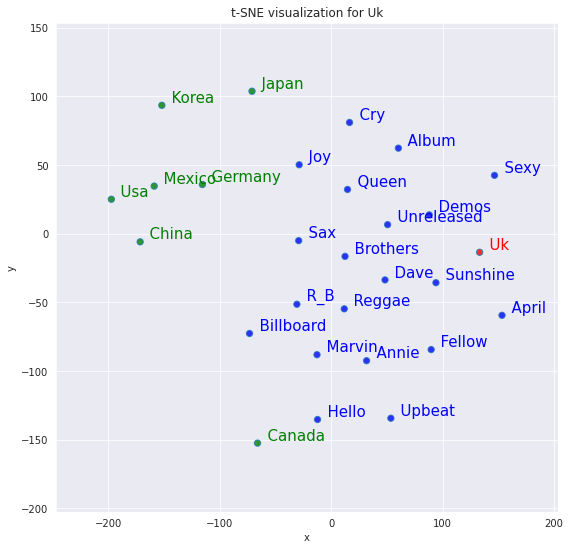

In [ ]:
import pandas as pd
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

tsnescatterplot(w2v_model, 'uk', ['canada', 'germany', 'china', 'usa', 'japan', 'korea', 'mexico'])
# ['belguim', 'hungary', 'netherlands', 'ravensburg', 'ravensburger', 'province', 'poland']

In [ ]:
vocab_set = set(w2v_model.wv.vocab)
pos_dict = []
for w in pos_list:
    if w in vocab_set:
        pos_dict.append(w)

neg_dict = []
for w in neg_list:
    if w in vocab_set:
        neg_dict.append(w)

print(len(pos_dict))
print(len(neg_dict))

515
603


In [ ]:
s_list = []
for w_pos in pos_dict:
    s_list.append((w_pos, w2v_model.wv.similarity(w_pos, 'china')))
for n_pos in neg_dict:
    s_list.append((n_pos, w2v_model.wv.similarity(n_pos, 'china')))

final_words = sorted(s_list, key= lambda k:k[-1])[::-1]
print(final_words)

pos_c = 0
neg_c = 0
for idx, w in enumerate(final_words):
    if idx >=50:
        print(w[-1])
        break
    if w[-1] <=0:
        break
    if w[0] in pos_dict:
        pos_c += 1
    if w[0] in neg_dict:
        neg_c += 1
print(pos_c, neg_c)
# cheap, cheaply, expensive, junk, hassle
# beware junk trash foremost reputable 10

[('beware', 0.7264166), ('gladly', 0.64701897), ('junk', 0.64645207), ('trash', 0.6205417), ('foremost', 0.599418), ('reputable', 0.59719944), ('garbage', 0.5967633), ('satisfied', 0.58945376), ('disappointed', 0.5809241), ('cheap', 0.5647176), ('ridiculous', 0.5644281), ('hesitant', 0.5643093), ('cheaply', 0.5631206), ('assurance', 0.56157506), ('trust', 0.55523443), ('faulty', 0.5524359), ('inferior', 0.5492385), ('shoddy', 0.5477595), ('concerned', 0.54695755), ('promptly', 0.5418961), ('defect', 0.5401902), ('deceptive', 0.53726035), ('defective', 0.53365445), ('false', 0.53058517), ('crap', 0.5238536), ('suspect', 0.5236347), ('cloudy', 0.5231591), ('sorry', 0.52249277), ('bother', 0.5121717), ('knock', 0.49428985), ('scam', 0.4938211), ('refund', 0.4860221), ('fake', 0.48549414), ('goodness', 0.48174256), ('boycott', 0.47990873), ('deter', 0.47434998), ('nervous', 0.4729158), ('downhill', 0.47094905), ('scared', 0.4704295), ('kill', 0.46965185), ('sick', 0.46906766), ('shocked', 

In [ ]:
s_list = []
for w_pos in pos_dict:
    s_list.append((w_pos, w2v_model.wv.similarity(w_pos, 'uk')))
for n_pos in neg_dict:
    s_list.append((n_pos, w2v_model.wv.similarity(n_pos, 'uk')))

final_words = sorted(s_list, key= lambda k:k[-1])[::-1]
print(final_words)

pos_c = 0
neg_c = 0
for idx, w in enumerate(final_words):
    if idx >=50:
        print(w[-1])
        break
    if w[-1] <=0:
        break
    if w[0] in pos_dict:
        pos_c += 1
    if w[0] in neg_dict:
        neg_c += 1
print(pos_c, neg_c)

[('sexy', 0.7139799), ('cry', 0.69152784), ('joy', 0.6913746), ('upbeat', 0.6808388), ('heaven', 0.6550828), ('refreshing', 0.652942), ('chill', 0.6340387), ('sublime', 0.60621315), ('funky', 0.60562927), ('brilliant', 0.59848404), ('greatness', 0.59750426), ('soulful', 0.5953599), ('breakthrough', 0.59427977), ('haunting', 0.5927212), ('instrumental', 0.58715475), ('holy', 0.5838948), ('understandable', 0.58262193), ('brilliance', 0.58092576), ('romantic', 0.5782392), ('harmony', 0.57751346), ('phenomenal', 0.5770082), ('glorious', 0.5726438), ('punk', 0.5717639), ('wow', 0.56629837), ('talent', 0.5651805), ('angel', 0.5639346), ('bitter', 0.56320935), ('profound', 0.5630957), ('sweet', 0.5621396), ('humorous', 0.5608834), ('contribution', 0.5596799), ('catchy', 0.55649674), ('moody', 0.5544246), ('uplifting', 0.5541031), ('stunning', 0.55183357), ('lonely', 0.55161947), ('deceive', 0.5494461), ('magic', 0.54865986), ('chic', 0.5456145), ('madness', 0.5439579), ('glory', 0.54391825), 

In [ ]:
s_list = []
for w_pos in pos_dict:
    s_list.append((w_pos, w2v_model.wv.similarity(w_pos, 'united_states')))
for n_pos in neg_dict:
    s_list.append((n_pos, w2v_model.wv.similarity(n_pos, 'united_states')))

final_words = sorted(s_list, key= lambda k:k[-1])[::-1]
print(final_words)
pos_c = 0
neg_c = 0
for idx, w in enumerate(final_words):
    if idx >=50:
        print(w[-1])
        break
    if w[-1] <=0:
        break
    if w[0] in pos_dict:
        pos_c += 1
    if w[0] in neg_dict:
        neg_c += 1
print(pos_c, neg_c)

# expensive, cheap, trust, safe, junk
# leery contamination pricey gladly questionable 10

[('taint', 0.7701098), ('strict', 0.7649811), ('illness', 0.7392255), ('assure', 0.71335113), ('trustworthy', 0.7099251), ('commitment', 0.6971734), ('sicken', 0.6891315), ('controversy', 0.6835352), ('controversial', 0.67198205), ('confidence', 0.6703552), ('scandal', 0.6667829), ('important', 0.66533285), ('strictly', 0.65697545), ('prominent', 0.6507138), ('deadly', 0.6494944), ('death', 0.6409667), ('trust', 0.6399733), ('suffer', 0.6398405), ('reputable', 0.63949025), ('contaminate', 0.635999), ('unhealthy', 0.62704194), ('danger', 0.62562793), ('harmful', 0.62227196), ('greed', 0.61917216), ('rumor', 0.6047704), ('decline', 0.60127926), ('loved', 0.6001168), ('assurance', 0.5992776), ('problematic', 0.59509045), ('adverse', 0.57371545), ('illegal', 0.5732189), ('suspicious', 0.56588143), ('oversight', 0.5607483), ('poison', 0.5606313), ('concern', 0.5587983), ('redeem', 0.55400324), ('beloved', 0.5539917), ('proud', 0.5508721), ('mystery', 0.55075413), ('questionable', 0.5443806)

In [ ]:
s_list = []
for w_pos in pos_dict:
    s_list.append((w_pos, w2v_model.wv.similarity(w_pos, 'japan')))
for n_pos in neg_dict:
    s_list.append((n_pos, w2v_model.wv.similarity(n_pos, 'japan')))

final_words = sorted(s_list, key= lambda k:k[-1])[::-1]
print(final_words)
pos_c = 0
neg_c = 0
for idx, w in enumerate(final_words):
    if idx >=50:
        print(w[-1])
        break
    if w[-1] <=0:
        break
    if w[0] in pos_dict:
        pos_c += 1
    if w[0] in neg_dict:
        neg_c += 1
print(pos_c, neg_c)

# master, well, superior, available, reputation
# [('fidelity', 0.5644529), ('humble', 0.5174113), ('integral', 0.51433253), ('muddy', 0.499482), ('devil', 0.47403237), ('inaccurate', 0.47266772), ('bonus', 0.4725

[('fidelity', 0.5644529), ('humble', 0.5174113), ('integral', 0.51433253), ('muddy', 0.499482), ('devil', 0.47403237), ('inaccurate', 0.47266772), ('bonus', 0.47258878), ('rival', 0.4704535), ('lament', 0.45181394), ('master', 0.44447967), ('amaze', 0.44226658), ('surpass', 0.44225383), ('clarity', 0.4391346), ('spite', 0.43853655), ('smoke', 0.422406), ('genuine', 0.41572043), ('fascinate', 0.41537938), ('burn', 0.41066965), ('lazy', 0.4080342), ('stellar', 0.40693125), ('nervous', 0.40475547), ('available', 0.3961162), ('snob', 0.38831335), ('fabulous', 0.3864929), ('bitter', 0.38449556), ('distort', 0.38261554), ('worthless', 0.3789063), ('loss', 0.37889808), ('understandable', 0.37431237), ('improved', 0.36672723), ('respectable', 0.3653051), ('wisely', 0.36477897), ('overlook', 0.35709515), ('myth', 0.35550693), ('reputation', 0.35462102), ('progressive', 0.35243842), ('accurately', 0.35143694), ('classic', 0.34951377), ('monster', 0.34397945), ('marvel', 0.34385893), ('unavailabl

In [ ]:
s_list = []
for w_pos in pos_dict:
    s_list.append((w_pos, w2v_model.wv.similarity(w_pos, 'korea')))
for n_pos in neg_dict:
    s_list.append((n_pos, w2v_model.wv.similarity(n_pos, 'korea')))
    
final_words = sorted(s_list, key= lambda k:k[-1])[::-1]
print(final_words)
pos_c = 0
neg_c = 0
for idx, w in enumerate(final_words):
    if idx >=50:
        print(w[-1])
        break
    if w[-1] <=0:
        break
    if w[0] in pos_dict:
        pos_c += 1
    if w[0] in neg_dict:
        neg_c += 1
print(pos_c, neg_c)

# protection, cheaply, protect, defender, beware, refund
# [('sleek', 0.65595216), ('defender', 0.63935333), ('genuine', 0.6109477), ('shocked', 0.60318846), ('fake', 0.58548236), ('shocking', 0.5537797), ('unlimited

[('sleek', 0.65595216), ('defender', 0.63935333), ('genuine', 0.6109477), ('shocked', 0.60318846), ('fake', 0.58548236), ('shocking', 0.5537797), ('unlimited', 0.5251889), ('responsive', 0.5193299), ('satisfactory', 0.51333666), ('expire', 0.5054719), ('disappoint', 0.5001537), ('prompt', 0.46991158), ('authentic', 0.46653003), ('cheaply', 0.45948732), ('luck', 0.45629433), ('smudge', 0.45132095), ('protective', 0.4491612), ('blah', 0.44412482), ('stylish', 0.43796444), ('beware', 0.43697715), ('syndrome', 0.43026426), ('cloudy', 0.42801416), ('scam', 0.42772803), ('matte', 0.42209458), ('refund', 0.42044216), ('deceive', 0.42013752), ('gripe', 0.41989183), ('unsure', 0.41484782), ('amaze', 0.41212356), ('wrinkle', 0.40919113), ('thank', 0.4076579), ('misalign', 0.4065205), ('hassle', 0.40347236), ('mislead', 0.40331), ('support', 0.39585453), ('protect', 0.3935545), ('error', 0.39350286), ('cumbersome', 0.39347327), ('broken', 0.39337048), ('ridiculously', 0.39170754), ('headache', 0.

In [ ]:
s_list = []
for w_pos in pos_dict:
    s_list.append((w_pos, w2v_model.wv.similarity(w_pos, 'germany')))
for n_pos in neg_dict:
    s_list.append((n_pos, w2v_model.wv.similarity(n_pos, 'germany')))

final_words = sorted(s_list, key= lambda k:k[-1])[::-1]
print(final_words)
pos_c = 0
neg_c = 0
for idx, w in enumerate(final_words):
    if idx >=50:
        print(w[-1])
        break
    if w[-1] <=0:
        break
    if w[0] in pos_dict:
        pos_c += 1
    if w[0] in neg_dict:
        neg_c += 1
print(pos_c, neg_c)

# superior, inferior, durable, inexpensive, reputation, precise
# [('abuse', 0.5099887), ('unacceptable', 0.50995195), ('skill', 0.49687517), ('wobble', 0.48954916), ('versatility', 0.46402898), ('rapid', 0.4600986), ('wise', 0.45794463), ('

[('abuse', 0.5099887), ('unacceptable', 0.50995195), ('skill', 0.49687517), ('wobble', 0.48954916), ('versatility', 0.46402898), ('rapid', 0.4600986), ('wise', 0.45794463), ('harden', 0.43591157), ('efficiently', 0.43339002), ('pleasure', 0.4313147), ('quibble', 0.43091056), ('merit', 0.42513958), ('best', 0.4246338), ('legendary', 0.41809723), ('incorrectly', 0.41808406), ('precise', 0.41611215), ('respect', 0.4135027), ('outstanding', 0.41290504), ('skilled', 0.4111874), ('excellent', 0.41112787), ('premier', 0.40607858), ('loyal', 0.40548354), ('stellar', 0.4036799), ('reputation', 0.403538), ('robust', 0.3993958), ('hollow', 0.39634436), ('shatter', 0.39360827), ('famous', 0.39174005), ('superior', 0.39170977), ('competitive', 0.39151478), ('champ', 0.39001593), ('overkill', 0.38592002), ('stability', 0.3775976), ('frustrate', 0.37646195), ('confidence', 0.3748145), ('devil', 0.3727986), ('warped', 0.3718532), ('refresh', 0.36972064), ('tough', 0.36829534), ('bash', 0.3656925), ('i

In [ ]:
s_list = []
for w_pos in pos_dict:
    s_list.append((w_pos, w2v_model.wv.similarity(w_pos, 'canada')))
for n_pos in neg_dict:
    s_list.append((n_pos, w2v_model.wv.similarity(n_pos, 'canada')))

final_words = sorted(s_list, key= lambda k:k[-1])[::-1]
print(final_words)
pos_c = 0
neg_c = 0
for idx, w in enumerate(final_words):
    if idx >=50:
        print(w[-1])
        break
    if w[-1] <=0:
        break
    if w[0] in pos_dict:
        pos_c += 1
    if w[0] in neg_dict:
        neg_c += 1
print(pos_c, neg_c)

# lucky, unbeatable, dent, mislead, available
# [('infection', 0.64918137), ('pride', 0.604856), ('allergy', 0.60215205), ('reassure', 0.590243), ('itch', 0.58345646), ('trustworthy', 0.533262), ('wary', 0.525596), ('suffer', 0.5018207), ('allergic', 0.49382997), ('strict', 0.48

[('infection', 0.64918137), ('pride', 0.604856), ('allergy', 0.60215205), ('reassure', 0.590243), ('itch', 0.58345646), ('trustworthy', 0.533262), ('wary', 0.525596), ('suffer', 0.5018207), ('allergic', 0.49382997), ('strict', 0.4884843), ('grateful', 0.48241007), ('thrive', 0.47761524), ('recommendation', 0.47715104), ('approve', 0.47471157), ('wild', 0.47224978), ('controversial', 0.46983165), ('healthy', 0.4546855), ('award', 0.45292693), ('overweight', 0.4398883), ('stink', 0.43062383), ('skeptical', 0.43011507), ('satisfied', 0.4287453), ('enthusiasm', 0.42734662), ('affordable', 0.41788918), ('variety', 0.4165834), ('finicky', 0.41404158), ('unhealthy', 0.41302407), ('offensive', 0.41221327), ('spoiled', 0.4121527), ('taint', 0.40764534), ('fat', 0.40655822), ('poison', 0.40576428), ('entice', 0.40430388), ('striking', 0.4037765), ('fresh', 0.40334105), ('miracle', 0.40189487), ('wholesome', 0.40135068), ('enthusiastically', 0.39583835), ('beloved', 0.39483598), ('picky', 0.39176

In [ ]:
s_list = []
for w_pos in pos_dict:
    s_list.append((w_pos, w2v_model.wv.similarity(w_pos, 'uk')))
for n_pos in neg_dict:
    s_list.append((n_pos, w2v_model.wv.similarity(n_pos, 'uk')))

final_words = sorted(s_list, key= lambda k:k[-1])[::-1]
print(final_words)
pos_c = 0
neg_c = 0
for idx, w in enumerate(final_words):
    if idx >=50:
        print(w[-1])
        break
    if w[-1] <=0:
        break
    if w[0] in pos_dict:
        pos_c += 1
    if w[0] in neg_dict:
        neg_c += 1
print(pos_c, neg_c)

# successful, success, breakthrough, masterpece, miss, classic
# [('sexy', 0.7139799), ('cry', 0.69152784), ('joy', 0.6913746), ('upbeat', 0.6808388), ('heaven', 0.6550828), ('refreshing', 0.652942), ('chill', 0.6340387), ('sublime', 0.60621315), ('f

[('sexy', 0.7139799), ('cry', 0.69152784), ('joy', 0.6913746), ('upbeat', 0.6808388), ('heaven', 0.6550828), ('refreshing', 0.652942), ('chill', 0.6340387), ('sublime', 0.60621315), ('funky', 0.60562927), ('brilliant', 0.59848404), ('greatness', 0.59750426), ('soulful', 0.5953599), ('breakthrough', 0.59427977), ('haunting', 0.5927212), ('instrumental', 0.58715475), ('holy', 0.5838948), ('understandable', 0.58262193), ('brilliance', 0.58092576), ('romantic', 0.5782392), ('harmony', 0.57751346), ('phenomenal', 0.5770082), ('glorious', 0.5726438), ('punk', 0.5717639), ('wow', 0.56629837), ('talent', 0.5651805), ('angel', 0.5639346), ('bitter', 0.56320935), ('profound', 0.5630957), ('sweet', 0.5621396), ('humorous', 0.5608834), ('contribution', 0.5596799), ('catchy', 0.55649674), ('moody', 0.5544246), ('uplifting', 0.5541031), ('stunning', 0.55183357), ('lonely', 0.55161947), ('deceive', 0.5494461), ('magic', 0.54865986), ('chic', 0.5456145), ('madness', 0.5439579), ('glory', 0.54391825), 

In [ ]:
s_list = []
for w_pos in pos_dict:
    s_list.append((w_pos, w2v_model.wv.similarity(w_pos, 'mexico')))
for n_pos in neg_dict:
    s_list.append((n_pos, w2v_model.wv.similarity(n_pos, 'mexico')))

final_words = sorted(s_list, key= lambda k:k[-1])[::-1]
print(final_words)
pos_c = 0
neg_c = 0
for idx, w in enumerate(final_words):
    if idx >=50:
        print(w[-1])
        break
    if w[-1] <=0:
        break
    if w[0] in pos_dict:
        pos_c += 1
    if w[0] in neg_dict:
        neg_c += 1
print(pos_c, neg_c)

# reputation, lousy, cheaply, defect, rigit, disappointed
# [('inferior', 0.6213755), ('inconsistent', 0.5885488), ('ugh', 0.5802709), ('shoddy', 0.5275038), ('gladly', 0.5260466), ('rant', 0.5159104), ('hesitant', 0.4993

[('inferior', 0.6213755), ('inconsistent', 0.5885488), ('ugh', 0.5802709), ('shoddy', 0.5275038), ('gladly', 0.5260466), ('rant', 0.5159104), ('hesitant', 0.4993999), ('disappointed', 0.49817398), ('rigid', 0.49478477), ('defect', 0.48925263), ('disappointment', 0.4865124), ('decline', 0.48362422), ('poorly', 0.48023313), ('wary', 0.46513748), ('cheaply', 0.46317652), ('junk', 0.46149564), ('beware', 0.44794935), ('confidence', 0.44349682), ('unable', 0.43921098), ('oversight', 0.4385422), ('competitive', 0.43786275), ('clog', 0.43643418), ('garbage', 0.43548134), ('overpriced', 0.43272075), ('blame', 0.43061683), ('useless', 0.42591545), ('satisfied', 0.42298815), ('sorry', 0.41785455), ('wobble', 0.41709468), ('roomy', 0.409278), ('fair', 0.4045893), ('sloppy', 0.40441814), ('reasonable', 0.40220731), ('greedy', 0.4015147), ('disappoint', 0.3999779), ('unfortunately', 0.39758635), ('reject', 0.39753413), ('comfy', 0.39515176), ('well', 0.39487514), ('inconvenience', 0.3913075), ('lee